# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.0+cpu  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [4]:
BATCH_SIZE = 32 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [6]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # 32*32*3 = 3072
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
  
    ######5번 코드######  
   


## 5. 초기화를 위한 함수 만들기

In [9]:
    def init_constants(m):
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight.data,0)
            nn.init.constant_(m.bias.data, 0)
        
    def init_normal(m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight)      

    def init_xaiver(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
        
    def init_kaiming(m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
        

## 6. 모델 객체 만들고 다르게 초기화 하기

In [10]:
########## 아래 채우시오에 함수명을 적으면됩니다.

network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xaiver = Model()
network_xaiver.apply(init_xaiver)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)


Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [11]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()

        # 이미지를 (batch_size, 784) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(batch_size, -1)

        # Forward propagration 계산하기.
        outputs = network(image) #forward함수 적용해야할수도
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = outputs.argmax(dim=1,keepdim=True)
        train_correct += pred.eq(label.view_as(pred)).sum().item()

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [12]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    test_losses = []

    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(batch_size, -1)

            # Forward propagration 계산하기.
            outputs = network(image)

            # Cross_entropy 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [13]:
def training(network):
    learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epoches):
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses, train_correct = training_epoch(train_loader, network, cls_loss, optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss)

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [14]:

rlt_const = training(network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.303845
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303636
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.303160

Training set: Accuracy: 4826/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.301823
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.303165
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303039
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.302925

Training set: Accuracy: 4949/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303060
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.306729
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303195
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.302672

Training set: Accuracy: 4851/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.301330
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.301723
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.301984
Train Epoch: 3 [48000/50000 (9

In [15]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 264.784882
Train Epoch: 0 [16000/50000 (32%)]	Loss: 28.235355
Train Epoch: 0 [32000/50000 (64%)]	Loss: 17.032209
Train Epoch: 0 [48000/50000 (96%)]	Loss: 13.135212

Training set: Accuracy: 12116/50000 (24%)
Test set: Accuracy: 2097/10000 (21%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 10.518990
Train Epoch: 1 [16000/50000 (32%)]	Loss: 8.085018
Train Epoch: 1 [32000/50000 (64%)]	Loss: 8.766990
Train Epoch: 1 [48000/50000 (96%)]	Loss: 8.593040

Training set: Accuracy: 11425/50000 (23%)
Test set: Accuracy: 1785/10000 (18%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 9.768984
Train Epoch: 2 [16000/50000 (32%)]	Loss: 6.533317
Train Epoch: 2 [32000/50000 (64%)]	Loss: 5.681694
Train Epoch: 2 [48000/50000 (96%)]	Loss: 8.777246

Training set: Accuracy: 11446/50000 (23%)
Test set: Accuracy: 2152/10000 (22%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 13.152656
Train Epoch: 3 [16000/50000 (32%)]	Loss: 3.916914
Train Epoch: 3 [32000/50000 (64%)]	Loss: 4.512106
Train Epoch: 3 [4800

In [16]:
rlt_xaiver = training(network_xaiver)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.540273
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.165004
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.365812
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.342787

Training set: Accuracy: 19617/50000 (39%)
Test set: Accuracy: 4399/10000 (44%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.600892
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.368104
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.255180
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.496901

Training set: Accuracy: 23295/50000 (47%)
Test set: Accuracy: 4639/10000 (46%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.283562
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.583131
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.507447
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.103311

Training set: Accuracy: 24768/50000 (50%)
Test set: Accuracy: 4809/10000 (48%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.382594
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.093063
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.736140
Train Epoch: 3 [48000/50000

In [17]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.498072
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.567175
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.930256
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.500981

Training set: Accuracy: 19796/50000 (40%)
Test set: Accuracy: 4451/10000 (45%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.389050
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.274917
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.772599
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.514505

Training set: Accuracy: 23366/50000 (47%)
Test set: Accuracy: 4680/10000 (47%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.494125
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.792162
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.455135
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.650521

Training set: Accuracy: 24931/50000 (50%)
Test set: Accuracy: 4764/10000 (48%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.157138
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.368480
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.320599
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [18]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

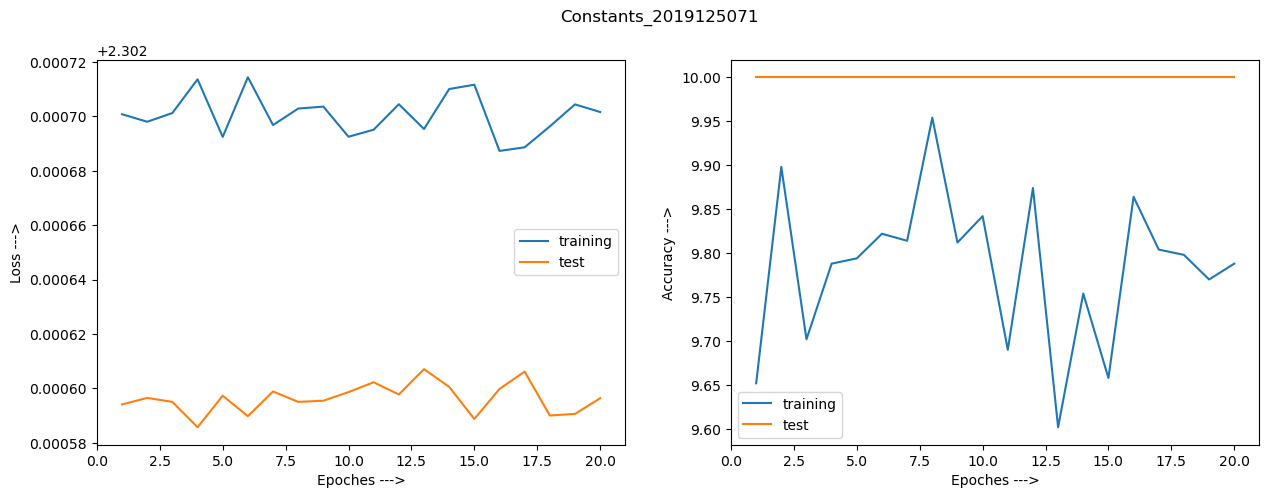

In [19]:
show_rlt(rlt_const, 'Constants_2019125071')

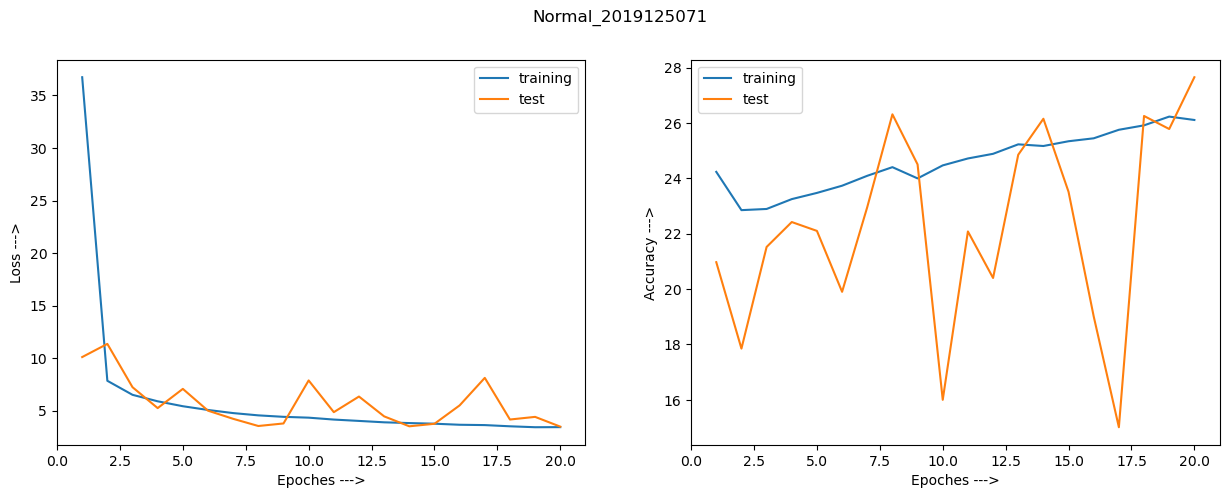

In [20]:
show_rlt(rlt_normal, 'Normal_2019125071')

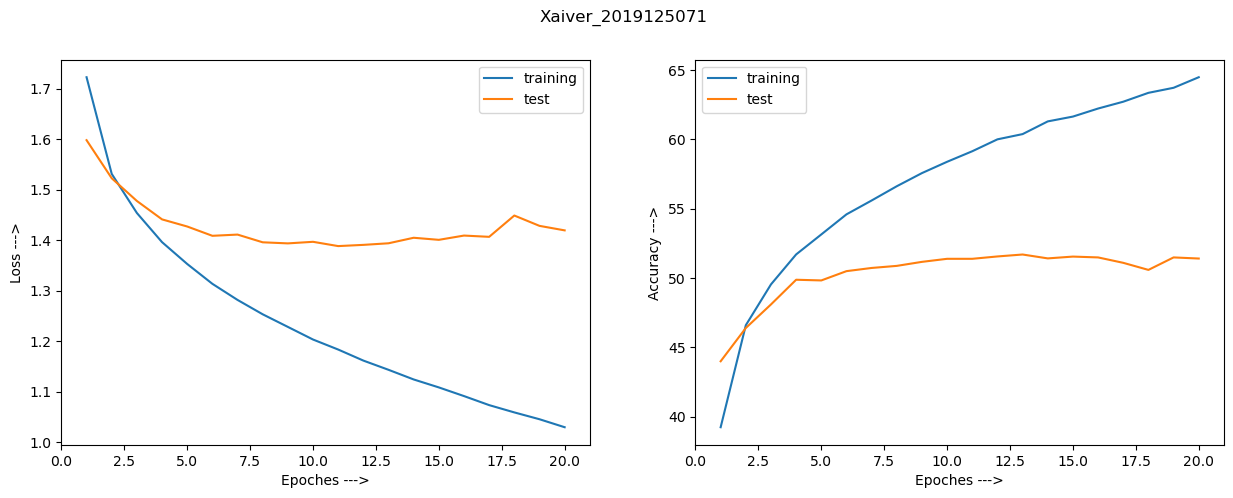

In [21]:
show_rlt(rlt_xaiver, 'Xaiver_2019125071')

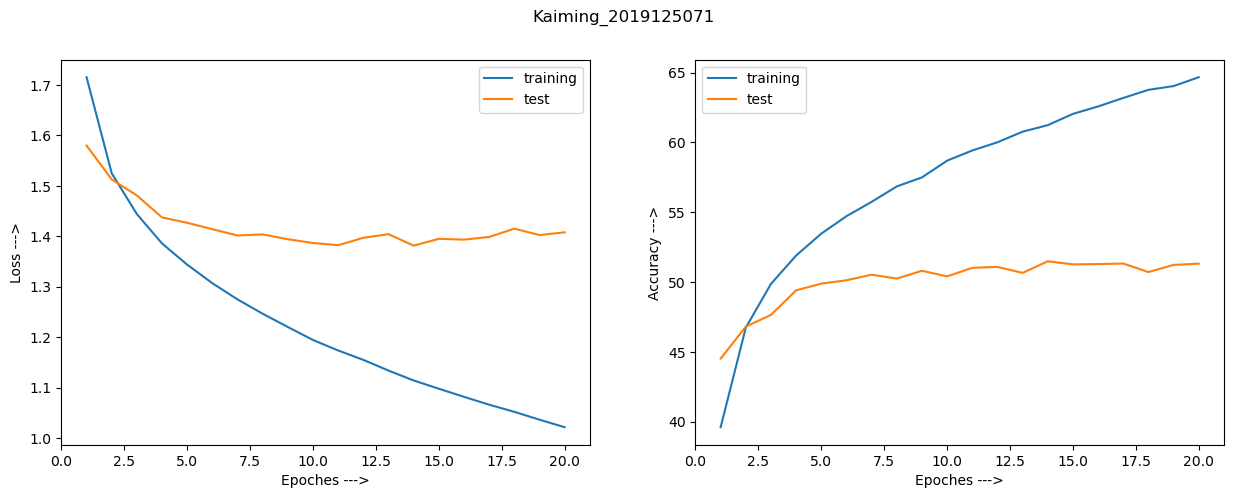

In [22]:
show_rlt(rlt_kaiming, 'Kaiming_2019125071')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답) **init_constant: 모든 가중치를 상수 값으로 초기화합니다.
init_normal: 평균이 0, 표준편차가 1인 정규분포에서 랜덤한 값을 가중치로 초기화합니다.
init_xaiver: 입력 뉴런 수와 출력 뉴런 수를 고려한 값으로 가중치를 초기화합니다.
init_kaiming: ReLU 함수를 사용하는 경우 입력 뉴런 수를 고려한 값으로 가중치를 초기화합니다.**

**각 epoch당 training set 과 test set의 정확도를 보았을때 xaiver 와 kaiming 초기화 방법을 사용했을때가 성능이 우수하다**